# IV HACKDAY CDS

### APRESENTAÇÃO FINAL - EQUIPE 08

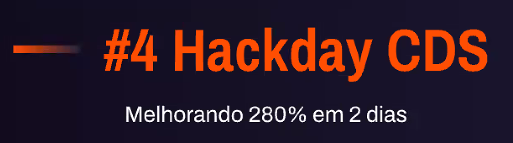

In [11]:
from PIL import Image
import io
import IPython.display as display

# carrega a imagem
img = Image.open('img/banner_hd.png')

# exibe a imagem dentro do notebook
buf = io.BytesIO()
img.save(buf, format='png')
display.display(display.Image(data=buf.getvalue()))

# Hotel Chain Cancellation Rating


### Agenda

1. Contexto
2. Desafio
3. Desenvolvimento da Solução
4. Conclusão
5. Próximos passos

1. Contexto

- Aumento na taxa de cancelamento da rede de hoteis Costa del Data, diferente do que era esperado após a retomada do setor hoteleiro com a Covid-19;
- Vale ressaltar que a Espanha está entre os maiores países afetados pela pandemia e possuem mais de 10% de participação do setor de viagens em suas economias.

2. Desafio

3. Desenvolvimento da Solução

In [1]:
# Import libs
import pandas                  as pd
import xgboost                 as xgb
from sklearn.ensemble          import RandomForestClassifier
from sklearn.preprocessing     import RobustScaler
from sklearn.model_selection   import cross_val_score
from category_encoders.count   import CountEncoder

In [ ]:
# Import Data
def get_data(path_train, path_test):
    # Dados de Treino
    data_train = pd.read_csv(path_train)
    # Dados de Teste
    data_test = pd.read_csv(path_test)
    # Retira a variável alvo
    X_train = data_train.drop(columns=['Reserva Cancelada'])
    # Seleciona somente a variável alvo
    y_train = data_train['Reserva Cancelada']
    # Atribui o dataset de teste
    X_test = data_test.copy()
    
    return X_train, y_train, X_test, data_test

In [ ]:
def preprocess_data(data):
    
    
    # Identificar as colunas numéricas
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    # Aplicar RobustScaler para transformar os dados numéricos
    rs = RobustScaler()
    rs.fit(data[numeric_cols])
    data[numeric_cols] = rs.transform(data[numeric_cols])
    
    # Identificar as colunas categóricas
    cat_cols = data.select_dtypes(include=['object']).columns
    # Usar CountEncoder para transformar as colunas categóricas em numéricas baseado na frequência
    count = CountEncoder(cols=cat_cols, return_df=True)
    X_preproc = count.fit_transform(data)
    
    # Preencher valores ausentes com 0
    X_preproc = X_preproc.fillna(0)
    
    return X_preproc

In [ ]:
def train_xgb(X_train_preproc, y_train):
    # Treinamento do Modelo usando o XGBoost
    xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                                    n_estimators = 600,
                                    eta = 0.01,
                                    max_depth = 20,
                                    subsample = 0.75,                       
                                    colsample_bytree = 0.9,
                                    random_state = 1)

    xgb_model.fit(X_train_preproc, y_train)

    return xgb_model

In [ ]:
def predict_xgb(model, X_test_preproc):   
    # Fazer a predição com o modelo treinado
    predicao_xgb = model.predict(X_test_preproc)
    
    return predicao_xgb

In [ ]:
def score(X_train, y_train, model):
    # Cálculo da métrica F1-Score
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    return print("F1-score Médio:", scores.mean())

In [ ]:
def export_file(data_test, predicao_xgb):
    # Concatena ID e variável alvo predita
    df_final = pd.concat([data_test.id, pd.Series(predicao_xgb, name = 'Reserva Cancelada')], axis=1)
    
    # Criar DataFrame final com as predições
    df_final.to_csv('submission.csv', index=False)
    
    return print('Arquivo csv criado com sucesso! Boa sorte na submissão!')

In [ ]:
if __name__ == "__main__":

    path_train = 'train.csv'
    path_test = 'test.csv'
    X_train, y_train, X_test, data_test = get_data(path_train, path_test)
    X_train_preproc  = preprocess_data(X_train)
    X_test_preproc   = preprocess_data(X_test)
    xgb_model = train_xgb(X_train_preproc, y_train)
    predicao_xgb = predict_xgb(xgb_model, X_test_preproc)
    score(X_train_preproc, y_train, xgb_model)
    export_file(data_test, predicao_xgb)